# Method 4 - Best Ideas Low Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Market Cap Adjusted Target

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance Adjusted Intra-Cap Weight Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data[
    'weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] < popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

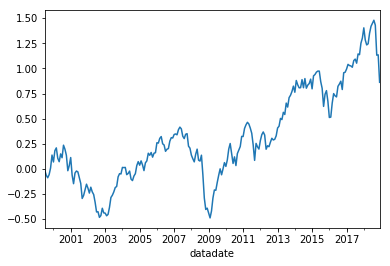

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.137553
2000-12-31   -0.092445
2001-12-31   -0.178730
2002-12-31   -0.336739
2003-12-31    0.688793
2004-12-31    0.129068
2005-12-31    0.082979
2006-12-31    0.125843
2007-12-31   -0.077312
2008-12-31   -0.494735
2009-12-31    0.743204
2010-12-31    0.245540
2011-12-31   -0.095303
2012-12-31    0.109895
2013-12-31    0.372249
2014-12-31    0.038079
2015-12-31   -0.116882
2016-12-31    0.173384
2017-12-31    0.173517
2018-12-31   -0.191388
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     730.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.42e-129
Time:                        11:51:33   Log-Likelihood:                 614.66
No. Observations:                 234   AIC:                            -1219.
Df Residuals:                     229   BIC:                            -1202.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.661      0.509      -0.003       0.002
mktrf          1.2033      0.033     36.478      0.000       1.138       1.268
me             0.4088      0.038     10.654      0.000       0.333       0.484
ia             0.0676      0.058      1.159      0.248      -0.047       0.183
roe           -0.2595      0.050     -5.198      0.000      -0.358      -0.161
==============================================================================
Omnibus:                        2.162   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                2.049
Skew:                           0.046   Prob(JB):                        0.359
Kurtosis:                       3.449   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     889.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.44e-138
Time:                        11:51:33   Log-Likelihood:                 614.66
No. Observations:                 234   AIC:                            -1219.
Df Residuals:                     229   BIC:                            -1202.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.634      0.526      -0.003       0.002
mktrf          1.2033      0.050     24.064      0.000       1.105       1.301
me             0.4088      0.080      5.141      0.000       0.253       0.565
ia             0.0676      0.077      0.881      0.378      -0.083       0.218
roe           -0.2595      0.078     -3.310      0.001      -0.413      -0.106
==============================================================================
Omnibus:                        2.162   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                2.049
Skew:                           0.046   Prob(JB):                        0.359
Kurtosis:                       3.449   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     1286.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.32e-155
Time:                        11:51:33   Log-Likelihood:                 614.66
No. Observations:                 234   AIC:                            -1219.
Df Residuals:                     229   BIC:                            -1202.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.673      0.501      -0.003       0.002
mktrf          1.2033      0.055     21.903      0.000       1.096       1.311
me             0.4088      0.085      4.816      0.000       0.242       0.575
ia             0.0676      0.076      0.885      0.376      -0.082       0.217
roe           -0.2595      0.087     -2.985      0.003      -0.430      -0.089
==============================================================================
Omnibus:                        2.162   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                2.049
Skew:                           0.046   Prob(JB):                        0.359
Kurtosis:                       3.449   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     501.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.00e-121
Time:                        11:51:33   Log-Likelihood:                 598.58
No. Observations:                 234   AIC:                            -1185.
Df Residuals:                     228   BIC:                            -1164.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -0.977      0.330      -0.004       0.001
mktrf          1.2316      0.035     34.709      0.000       1.162       1.301
smb            0.4735      0.047     10.114      0.000       0.381       0.566
hml            0.1460      0.055      2.644      0.009       0.037       0.255
rmw           -0.1736      0.062     -2.782      0.006      -0.297      -0.051
cma           -0.0627      0.079     -0.791      0.430      -0.219       0.094
==============================================================================
Omnibus:                       10.662   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.872
Skew:                           0.315   Prob(JB):                     0.000590
Kurtosis:                       4.062   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     565.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.77e-126
Time:                        11:51:33   Log-Likelihood:                 598.58
No. Observations:                 234   AIC:                            -1185.
Df Residuals:                     228   BIC:                            -1164.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -0.923      0.356      -0.004       0.001
mktrf          1.2316      0.044     27.914      0.000       1.145       1.318
smb            0.4735      0.062      7.692      0.000       0.353       0.594
hml            0.1460      0.091      1.611      0.107      -0.032       0.324
rmw           -0.1736      0.088     -1.977      0.048      -0.346      -0.002
cma           -0.0627      0.096     -0.652      0.515      -0.251       0.126
==============================================================================
Omnibus:                       10.662   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.872
Skew:                           0.315   Prob(JB):                     0.000590
Kurtosis:                       4.062   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     866.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.90e-146
Time:                        11:51:33   Log-Likelihood:                 598.58
No. Observations:                 234   AIC:                            -1185.
Df Residuals:                     228   BIC:                            -1164.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -0.904      0.366      -0.004       0.001
mktrf          1.2316      0.045     27.434      0.000       1.144       1.320
smb            0.4735      0.066      7.146      0.000       0.344       0.603
hml            0.1460      0.080      1.826      0.068      -0.011       0.303
rmw           -0.1736      0.095     -1.822      0.068      -0.360       0.013
cma           -0.0627      0.093     -0.674      0.501      -0.245       0.120
==============================================================================
Omnibus:                       10.662   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.872
Skew:                           0.315   Prob(JB):                     0.000590
Kurtosis:                       4.062   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     694.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.77e-127
Time:                        11:51:33   Log-Likelihood:                 609.14
No. Observations:                 234   AIC:                            -1208.
Df Residuals:                     229   BIC:                            -1191.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.064      0.289      -0.004       0.001
mktrf          1.2083      0.031     38.855      0.000       1.147       1.270
smb            0.5530      0.039     14.246      0.000       0.477       0.629
hml            0.1249      0.039      3.240      0.001       0.049       0.201
umd           -0.1565      0.025     -6.188      0.000      -0.206      -0.107
==============================================================================
Omnibus:                        2.270   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                2.198
Skew:                           0.044   Prob(JB):                        0.333
Kurtosis:                       3.466   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     1088.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.15e-147
Time:                        11:51:33   Log-Likelihood:                 609.14
No. Observations:                 234   AIC:                            -1208.
Df Residuals:                     229   BIC:                            -1191.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.013      0.311      -0.004       0.001
mktrf          1.2083      0.040     30.429      0.000       1.130       1.286
smb            0.5530      0.065      8.543      0.000       0.426       0.680
hml            0.1249      0.056      2.238      0.025       0.016       0.234
umd           -0.1565      0.038     -4.119      0.000      -0.231      -0.082
==============================================================================
Omnibus:                        2.270   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                2.198
Skew:                           0.044   Prob(JB):                        0.333
Kurtosis:                       3.466   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     1320.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.99e-157
Time:                        11:51:33   Log-Likelihood:                 609.14
No. Observations:                 234   AIC:                            -1208.
Df Residuals:                     229   BIC:                            -1191.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.048      0.295      -0.004       0.001
mktrf          1.2083      0.041     29.719      0.000       1.129       1.288
smb            0.5530      0.074      7.510      0.000       0.409       0.697
hml            0.1249      0.058      2.152      0.031       0.011       0.239
umd           -0.1565      0.035     -4.531      0.000      -0.224      -0.089
==============================================================================
Omnibus:                        2.270   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                2.198
Skew:                           0.044   Prob(JB):                        0.333
Kurtosis:                       3.466   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     354.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.11e-63
Time:                        11:51:33   Log-Likelihood:                 296.79
No. Observations:                 120   AIC:                            -583.6
Df Residuals:                     115   BIC:                            -569.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.678      0.499      -0.003       0.005
mktrf          1.2859      0.054     23.940      0.000       1.179       1.392
me             0.3674      0.053      6.925      0.000       0.262       0.472
ia             0.0512      0.083      0.616      0.539      -0.113       0.216
roe           -0.1740      0.074     -2.366      0.020      -0.320      -0.028
==============================================================================
Omnibus:                        0.126   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.071
Skew:                          -0.058   Prob(JB):                        0.965
Kurtosis:                       2.971   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     489.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.33e-71
Time:                        11:51:33   Log-Likelihood:                 296.79
No. Observations:                 120   AIC:                            -583.6
Df Residuals:                     115   BIC:                            -569.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.608      0.543      -0.003       0.006
mktrf          1.2859      0.064     20.228      0.000       1.161       1.410
me             0.3674      0.083      4.429      0.000       0.205       0.530
ia             0.0512      0.092      0.555      0.579      -0.130       0.232
roe           -0.1740      0.093     -1.867      0.062      -0.357       0.009
==============================================================================
Omnibus:                        0.126   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.071
Skew:                          -0.058   Prob(JB):                        0.965
Kurtosis:                       2.971   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     758.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-81
Time:                        11:51:33   Log-Likelihood:                 296.79
No. Observations:                 120   AIC:                            -583.6
Df Residuals:                     115   BIC:                            -569.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.678      0.497      -0.003       0.005
mktrf          1.2859      0.066     19.541      0.000       1.157       1.415
me             0.3674      0.089      4.140      0.000       0.193       0.541
ia             0.0512      0.087      0.587      0.557      -0.120       0.222
roe           -0.1740      0.096     -1.809      0.070      -0.362       0.015
==============================================================================
Omnibus:                        0.126   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.071
Skew:                          -0.058   Prob(JB):                        0.965
Kurtosis:                       2.971   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     250.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.07e-59
Time:                        11:51:33   Log-Likelihood:                 290.28
No. Observations:                 120   AIC:                            -568.6
Df Residuals:                     114   BIC:                            -551.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.835      0.405      -0.002       0.006
mktrf          1.3353      0.060     22.233      0.000       1.216       1.454
smb            0.4423      0.068      6.502      0.000       0.308       0.577
hml            0.0761      0.083      0.913      0.363      -0.089       0.241
rmw           -0.0955      0.098     -0.972      0.333      -0.290       0.099
cma           -0.0221      0.108     -0.205      0.838      -0.235       0.191
==============================================================================
Omnibus:                        1.409   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                0.953
Skew:                           0.178   Prob(JB):                        0.621
Kurtosis:                       3.251   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     349.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.20e-67
Time:                        11:51:33   Log-Likelihood:                 290.28
No. Observations:                 120   AIC:                            -568.6
Df Residuals:                     114   BIC:                            -551.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.852      0.394      -0.002       0.006
mktrf          1.3353      0.068     19.739      0.000       1.203       1.468
smb            0.4423      0.076      5.803      0.000       0.293       0.592
hml            0.0761      0.135      0.563      0.574      -0.189       0.341
rmw           -0.0955      0.124     -0.768      0.443      -0.340       0.148
cma           -0.0221      0.113     -0.196      0.845      -0.243       0.199
==============================================================================
Omnibus:                        1.409   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                0.953
Skew:                           0.178   Prob(JB):                        0.621
Kurtosis:                       3.251   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     623.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.12e-81
Time:                        11:51:33   Log-Likelihood:                 290.28
No. Observations:                 120   AIC:                            -568.6
Df Residuals:                     114   BIC:                            -551.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.001      0.317      -0.002       0.005
mktrf          1.3353      0.065     20.623      0.000       1.208       1.462
smb            0.4423      0.078      5.636      0.000       0.288       0.596
hml            0.0761      0.127      0.598      0.550      -0.173       0.325
rmw           -0.0955      0.137     -0.699      0.484      -0.363       0.172
cma           -0.0221      0.099     -0.222      0.824      -0.217       0.173
==============================================================================
Omnibus:                        1.409   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                0.953
Skew:                           0.178   Prob(JB):                        0.621
Kurtosis:                       3.251   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     333.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.80e-62
Time:                        11:51:33   Log-Likelihood:                 293.42
No. Observations:                 120   AIC:                            -576.8
Df Residuals:                     115   BIC:                            -562.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.880      0.381      -0.002       0.006
mktrf          1.2935      0.049     26.577      0.000       1.197       1.390
smb            0.4948      0.055      8.929      0.000       0.385       0.605
hml            0.1070      0.056      1.928      0.056      -0.003       0.217
umd           -0.1203      0.034     -3.515      0.001      -0.188      -0.053
==============================================================================
Omnibus:                        0.840   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.657   Jarque-Bera (JB):                0.520
Skew:                          -0.146   Prob(JB):                        0.771
Kurtosis:                       3.137   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     677.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.28e-79
Time:                        11:51:33   Log-Likelihood:                 293.42
No. Observations:                 120   AIC:                            -576.8
Df Residuals:                     115   BIC:                            -562.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.849      0.396      -0.002       0.006
mktrf          1.2935      0.048     26.731      0.000       1.199       1.388
smb            0.4948      0.075      6.594      0.000       0.348       0.642
hml            0.1070      0.080      1.343      0.179      -0.049       0.263
umd           -0.1203      0.041     -2.948      0.003      -0.200      -0.040
==============================================================================
Omnibus:                        0.840   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.657   Jarque-Bera (JB):                0.520
Skew:                          -0.146   Prob(JB):                        0.771
Kurtosis:                       3.137   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     1056.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.25e-89
Time:                        11:51:33   Log-Likelihood:                 293.42
No. Observations:                 120   AIC:                            -576.8
Df Residuals:                     115   BIC:                            -562.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      0.931      0.352      -0.002       0.005
mktrf          1.2935      0.044     29.634      0.000       1.208       1.379
smb            0.4948      0.084      5.879      0.000       0.330       0.660
hml            0.1070      0.085      1.262      0.207      -0.059       0.273
umd           -0.1203      0.035     -3.475      0.001      -0.188      -0.052
==============================================================================
Omnibus:                        0.840   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.657   Jarque-Bera (JB):                0.520
Skew:                          -0.146   Prob(JB):                        0.771
Kurtosis:                       3.137   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     493.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.83e-69
Time:                        11:51:33   Log-Likelihood:                 342.00
No. Observations:                 114   AIC:                            -674.0
Df Residuals:                     109   BIC:                            -660.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.399      0.165      -0.004       0.001
mktrf          1.0919      0.036     30.147      0.000       1.020       1.164
me             0.5564      0.056      9.950      0.000       0.446       0.667
ia             0.0648      0.078      0.836      0.405      -0.089       0.219
roe           -0.3950      0.068     -5.796      0.000      -0.530      -0.260
==============================================================================
Omnibus:                        1.700   Durbin-Watson:                   2.304
Prob(Omnibus):                  0.427   Jarque-Bera (JB):                1.350
Skew:                           0.261   Prob(JB):                        0.509
Kurtosis:                       3.103   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1808.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.25e-98
Time:                        11:51:33   Log-Likelihood:                 342.00
No. Observations:                 114   AIC:                            -674.0
Df Residuals:                     109   BIC:                            -660.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.593      0.111      -0.004       0.000
mktrf          1.0919      0.041     26.418      0.000       1.011       1.173
me             0.5564      0.057      9.716      0.000       0.444       0.669
ia             0.0648      0.084      0.770      0.441      -0.100       0.230
roe           -0.3950      0.077     -5.132      0.000      -0.546      -0.244
==============================================================================
Omnibus:                        1.700   Durbin-Watson:                   2.304
Prob(Omnibus):                  0.427   Jarque-Bera (JB):                1.350
Skew:                           0.261   Prob(JB):                        0.509
Kurtosis:                       3.103   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     2489.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.18e-106
Time:                        11:51:33   Log-Likelihood:                 342.00
No. Observations:                 114   AIC:                            -674.0
Df Residuals:                     109   BIC:                            -660.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.757      0.079      -0.004       0.000
mktrf          1.0919      0.039     27.858      0.000       1.015       1.169
me             0.5564      0.048     11.639      0.000       0.463       0.650
ia             0.0648      0.097      0.671      0.502      -0.125       0.254
roe           -0.3950      0.086     -4.570      0.000      -0.564      -0.226
==============================================================================
Omnibus:                        1.700   Durbin-Watson:                   2.304
Prob(Omnibus):                  0.427   Jarque-Bera (JB):                1.350
Skew:                           0.261   Prob(JB):                        0.509
Kurtosis:                       3.103   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     313.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.37e-62
Time:                        11:51:34   Log-Likelihood:                 330.15
No. Observations:                 114   AIC:                            -648.3
Df Residuals:                     108   BIC:                            -631.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.001     -2.482      0.015      -0.006      -0.001
mktrf          1.1245      0.039     29.203      0.000       1.048       1.201
smb            0.5799      0.063      9.276      0.000       0.456       0.704
hml            0.1671      0.080      2.096      0.038       0.009       0.325
rmw           -0.1620      0.098     -1.659      0.100      -0.355       0.032
cma            0.0183      0.124      0.148      0.883      -0.227       0.264
==============================================================================
Omnibus:                        2.171   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.338   Jarque-Bera (JB):                1.690
Skew:                          -0.154   Prob(JB):                        0.430
Kurtosis:                       3.511   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     584.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.94e-76
Time:                        11:51:34   Log-Likelihood:                 330.15
No. Observations:                 114   AIC:                            -648.3
Df Residuals:                     108   BIC:                            -631.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.001     -2.959      0.003      -0.006      -0.001
mktrf          1.1245      0.035     31.798      0.000       1.055       1.194
smb            0.5799      0.072      8.100      0.000       0.440       0.720
hml            0.1671      0.094      1.782      0.075      -0.017       0.351
rmw           -0.1620      0.082     -1.984      0.047      -0.322      -0.002
cma            0.0183      0.151      0.121      0.903      -0.277       0.314
==============================================================================
Omnibus:                        2.171   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.338   Jarque-Bera (JB):                1.690
Skew:                          -0.154   Prob(JB):                        0.430
Kurtosis:                       3.511   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     709.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.48e-81
Time:                        11:51:34   Log-Likelihood:                 330.15
No. Observations:                 114   AIC:                            -648.3
Df Residuals:                     108   BIC:                            -631.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.001     -2.835      0.005      -0.006      -0.001
mktrf          1.1245      0.031     35.876      0.000       1.063       1.186
smb            0.5799      0.062      9.291      0.000       0.458       0.702
hml            0.1671      0.100      1.667      0.096      -0.029       0.364
rmw           -0.1620      0.071     -2.292      0.022      -0.300      -0.023
cma            0.0183      0.177      0.103      0.918      -0.329       0.366
==============================================================================
Omnibus:                        2.171   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.338   Jarque-Bera (JB):                1.690
Skew:                          -0.154   Prob(JB):                        0.430
Kurtosis:                       3.511   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     468.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.17e-67
Time:                        11:51:34   Log-Likelihood:                 339.17
No. Observations:                 114   AIC:                            -668.3
Df Residuals:                     109   BIC:                            -654.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.001     -2.328      0.022      -0.005      -0.000
mktrf          1.1102      0.035     31.551      0.000       1.040       1.180
smb            0.6308      0.055     11.496      0.000       0.522       0.740
hml            0.1484      0.057      2.625      0.010       0.036       0.260
umd           -0.2098      0.043     -4.922      0.000      -0.294      -0.125
==============================================================================
Omnibus:                        0.218   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.180
Skew:                          -0.094   Prob(JB):                        0.914
Kurtosis:                       2.947   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     1409.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.77e-93
Time:                        11:51:34   Log-Likelihood:                 339.17
No. Observations:                 114   AIC:                            -668.3
Df Residuals:                     109   BIC:                            -654.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.001     -3.020      0.003      -0.005      -0.001
mktrf          1.1102      0.036     30.980      0.000       1.040       1.180
smb            0.6308      0.072      8.796      0.000       0.490       0.771
hml            0.1484      0.065      2.266      0.023       0.020       0.277
umd           -0.2098      0.057     -3.682      0.000      -0.321      -0.098
==============================================================================
Omnibus:                        0.218   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.180
Skew:                          -0.094   Prob(JB):                        0.914
Kurtosis:                       2.947   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     3050.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.30e-111
Time:                        11:51:34   Log-Likelihood:                 339.17
No. Observations:                 114   AIC:                            -668.3
Df Residuals:                     109   BIC:                            -654.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.001     -3.519      0.000      -0.005      -0.001
mktrf          1.1102      0.032     34.461      0.000       1.047       1.173
smb            0.6308      0.063      9.936      0.000       0.506       0.755
hml            0.1484      0.067      2.216      0.027       0.017       0.280
umd           -0.2098      0.058     -3.630      0.000      -0.323      -0.097
==============================================================================
Omnibus:                        0.218   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.180
Skew:                          -0.094   Prob(JB):                        0.914
Kurtosis:                       2.947   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""